In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cv2 as cv
import plotly.plotly as py
import htmlPy


ImportError: DLL load failed: The specified procedure could not be found.

In [2]:
RESIZ = 0.1
PATH = "we.jpg"

(1912L, 2560L, 3L)
(1912L, 2560L, 3L)   Size = 14.68416  Mega pixels


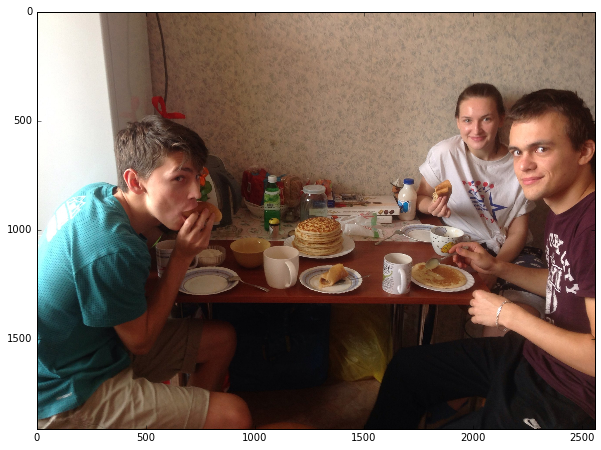

In [412]:
img = cv.imread(PATH)
print np.asarray(img).shape
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#img = cv.resize(img,None,fx=RESIZ,fy=RESIZ)
print np.asarray(img).shape,"  Size =",img.size/1000000.," Mega pixels"
plt.figure(figsize = (10,8))
plt.imshow(img)

SIZ = img.size

In [204]:
import plotly.graph_objs as go
py.sign_in('Jill.Osw', 'qobzfjo1zu')
from plotly.graph_objs import *

def plot_sc(inp,classes = 0,size=10):
    if (classes==0):classes = np.ones((inp.shape[0]))
    print classes.shape
    x, y, z = inp.transpose()
    rs = np.asarray(classes)
    print range(1,np.unique(classes)+1)
    data=[
     go.Scatter3d(x=x[rs==i],
                  y=y[rs==i],              
                  z=z[rs==i],
                  mode='markers',
                  marker=dict(size=size,line=dict(width=0.5,color = 'rgba(10, 10, 10, .4)'),opacity=0.8))
                for i in range(1,np.unique(classes)+1)]

    layout = go.Layout(        margin=dict(l=0,r=0,b=0,t=0)    )
    fig = go.Figure(data=data, layout=layout)
    return fig
    #py.iplot(fig)

In [205]:
img_gray =img.mean(2)
dots = np.zeros((SIZ/3,3))
n=0
for i in np.arange(img.shape[0]):
    for j in np.arange(img.shape[1]):
        dots[n]=[i,j,img_gray[i,j]]
        n=n+1
fig  = plot_sc(dots,size=5)
py.iplot(fig)

(6030L,)
[1]


In [235]:
X =  np.zeros((SIZ/3,5))
n=0
for i in np.arange(img.shape[0]):
    for j in np.arange(img.shape[1]):
        X[n]=[i*3,j*3,img[i,j,0],img[i,j,1],img[i,j,2]]
        n=n+1
print X

[[   0.    0.  253.  253.  241.]
 [   0.    3.  246.  242.  231.]
 [   0.    6.  237.  227.  217.]
 ..., 
 [  54.   69.   33.   29.   28.]
 [  54.   72.   25.   19.   19.]
 [  54.   75.   48.   24.   27.]]


In [236]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.
colors = cm.rainbow(np.linspace(0, 1, 1))

In [237]:

tsne = TSNE(random_state=321)
%time tsne_representation = tsne.fit_transform(X)


Wall time: 5.35 s


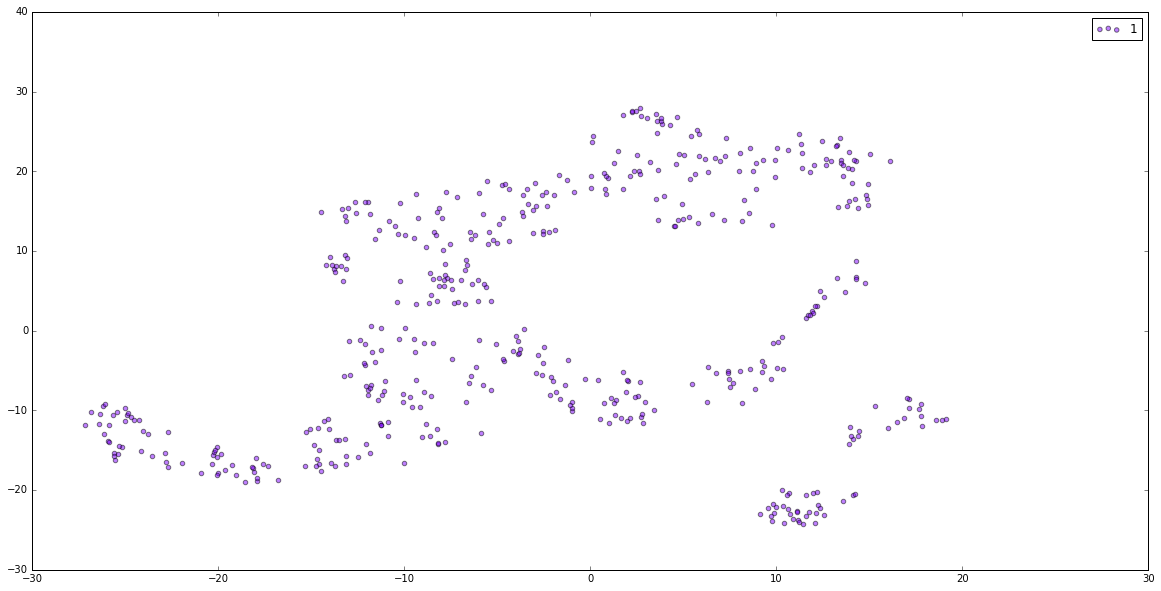

In [238]:
#print tsne_representation
plt.figure(figsize=(20,10))
for y, c in zip([1], colors):
    plt.scatter(tsne_representation[:, 0], 
                tsne_representation[:, 1], c=c, alpha=0.5, label=str(y))
plt.legend()


In [6]:
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler ,MinMaxScaler

In [3]:
def lightcorr(img):
    #-----Converting image to LAB Color model----------------------------------- 
    lab= cv.cvtColor(img, cv.COLOR_BGR2LAB)
    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv.split(lab)
    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(4,4))
    cl = clahe.apply(l)
    #cl = cv.equalizeHist(l)
    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv.merge((cl,a,b))
    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv.cvtColor(limg, cv.COLOR_LAB2BGR)
    return final


def colorcorr(img):
    #-----Converting image to HSV Color model----------------------------------- 
    hsv= cv.cvtColor(img, cv.COLOR_BGR2HSV)
    #-----Splitting the HSV image to different channels-------------------------
    h,s,v = cv.split(hsv)
    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(1,1))
    cl = clahe.apply(s)
    #cl = cv.equalizeHist(h)
    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv.merge((h,cl,v))
    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv.cvtColor(limg, cv.COLOR_HSV2BGR)
    return final
    

In [42]:
def ifnoiz(v):
    if(v==-1): return 0
    else: return 1
def clust_im(img,resiz = 0,siz =10,eps=0.04,k=2.):
    if (len(img.shape)==3): 
        gray =False
        imsize = img.size/3.
    else:
        gray=True
        imsize = img.size
    
    if (resiz==0): RESIZ = np.sqrt((siz*1000.)/imsize)
    print"input shape:",img.shape, "resizing coeff =",RESIZ
    img = cv.resize(img,None,fx=RESIZ,fy=RESIZ)
    img = lightcorr(img)
    img=  colorcorr(img)
    
    imsize = (img.size/3)
    if gray: imsize = (img.size)
    print "resized image size =", imsize,"shape:",img.shape
    X =  np.zeros((imsize,5))
    n=0
    for i in np.arange(img.shape[0]):
        for j in np.arange(img.shape[1]):
            X[n]=[i,j,img[i,j,0],img[i,j,1],img[i,j,2]]
            n=n+1
            
    sc =MinMaxScaler()    
    X= sc.fit_transform(X)
    X = [[X[i,0]*k,X[i,1]*k,X[i,2],X[i,3],X[i,4]] for i in np.arange(n)]
    
    cls = DBSCAN(eps=eps)
    labs = cls.fit_predict(X)
        
    im_cl = np.zeros((img.shape[0],img.shape[1]))
    n=0
    m = max(labs+1)
    for i in np.arange(img.shape[0]):
        for j in np.arange(img.shape[1]):
            im_cl[i,j] = ((labs[n]))*256/m
            n=n+1
    return im_cl,m

In [39]:
print X
sc =MinMaxScaler()
X= sc.fit_transform(X)
print X
cls = DBSCAN(eps=0.04)

%time labs = cls.fit_predict(X)

NameError: name 'X' is not defined

In [144]:

img = cv.imread("smb2.jpg")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

input shape: (682L, 683L, 3L) resizing coeff = 0.103605416988
resized image size = 5041 shape: (71L, 71L, 3L)
23 clusters


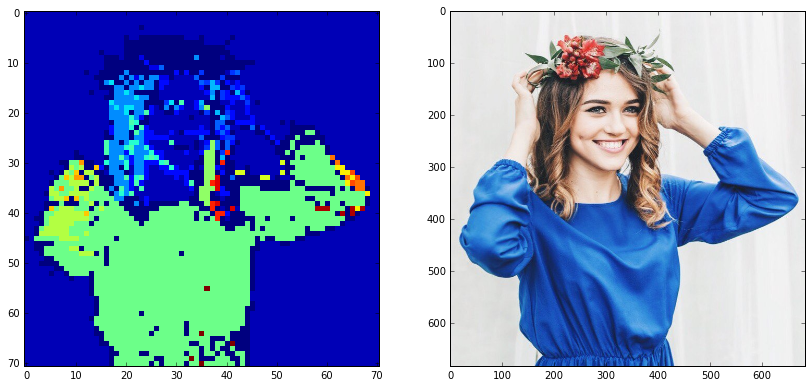

In [145]:

    
fig, ax = plt.subplots(1,2,figsize=(14, 8))

imcl,m =clust_im(img,siz=5,eps=0.0473,k=0.3)
print m,"clusters"
ax[0].imshow(imcl,interpolation="nearest")
ax[1].imshow(img)


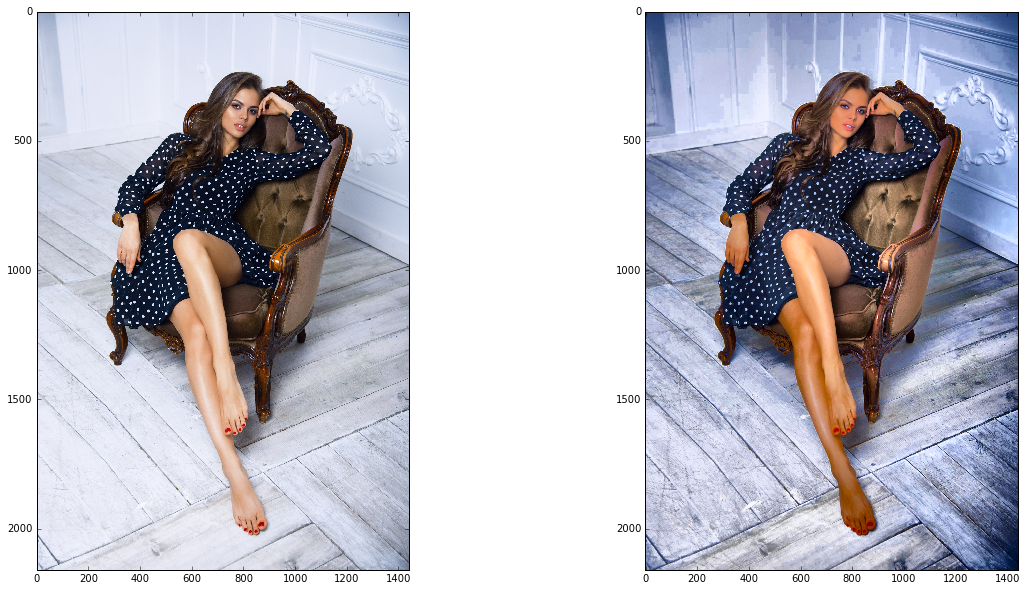

In [137]:

fig, ax = plt.subplots(1,2,figsize=(20, 10))
ax[0].imshow(img,interpolation="nearest")
ax[1].imshow(lightcorr(colorcorr(img)))


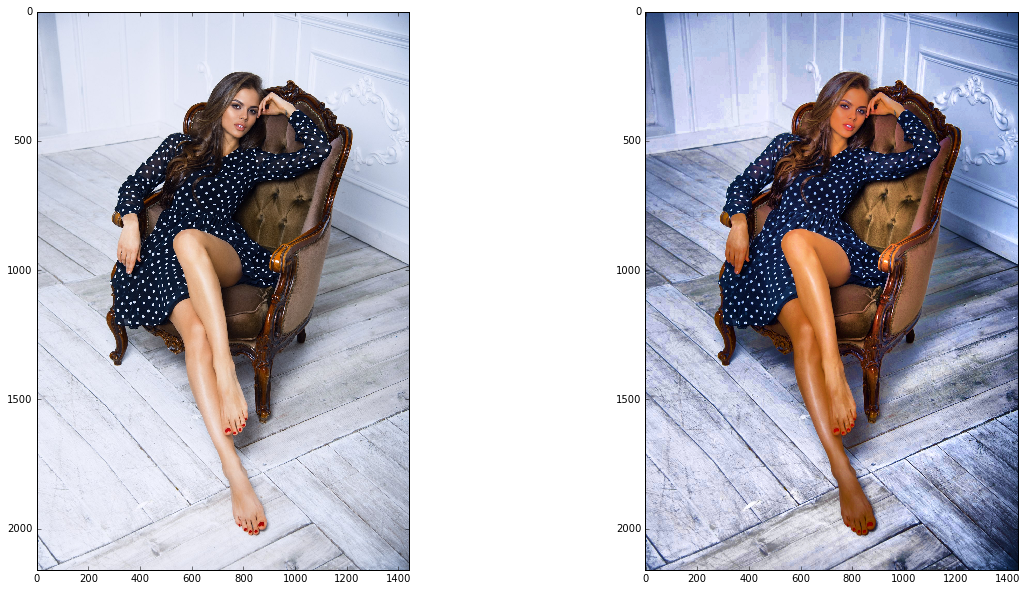

In [138]:

fig, ax = plt.subplots(1,2,figsize=(20, 10))
ax[0].imshow(img,interpolation="nearest")
ax[1].imshow(colorcorr(lightcorr(img)))